#### クラス編成
- 課題整理(条件)
  - 全生徒を1つのクラスに割り当てる
  - クラス人数は39人以上40人以下
  - 男子生徒、女子生徒は20人以下
  - 学力試験のクラス平均点は学年平均の±10点
  - リーダ気質の生徒を2人以上
  - 特別支援生徒は1人以下
  - 特定ペアの生徒は別クラスとする

- List
  - $S$ : Students list
  - $C$ : Class list
  - $S_{male}$ : Men list
  - $S_{female}$ : Women list
  - $S_{leader}$ : leaders list
  - $S_{support}$ : supports list
  - $S_{specific}$ : Specific Pairs list
- Variable
  - $x_{s,c} \in \{0, 1\} (s\in S, c\in C)$
- Constant
  - $score_s$ : Score of students
  - $score_{mean}$ : Score of mean
- Constraints
  1. $\sum_{c\in C} x_{s,c} = 1 \quad (s \in S)$
  2. $\sum_{s\in S} x_{s,c} \ge 39 \quad (c \in C), \quad \sum_{s\in S} x_{s,c} \le 40 \quad (c \in C)$
  3. $\sum_{s\in S_{male}} x_{s,c} \le 20 \quad (c \in C), \quad \sum_{s\in S_{female}} x_{s,c} \le 20 \quad (c \in C)$
  4. $\sum_{S_{leader}}x_{s,c} \le 2$
  5. $\sum_{S_{support}}x_{s,c} \le 1$
  6. $(score_{mean}-10) \cdot \sum_{s\in S} x_{s,c} \ge \sum_{s\in S} score_s \cdot x_{s,c}, \quad \sum_{s\in S} score_s \cdot x_{s,c} \le (score_{mean}+10) \cdot \sum_{s\in S} x_{s,c}$
  7. $x_{s1,c} + x_{s2,c} \le 1$
- Objective
  - None(Maximize)

In [435]:
from pulp import LpProblem, LpVariable, LpMaximize, LpStatus, lpSum, value
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import math
from itertools import product

In [258]:
glob('../*/*school/*.csv')
students_df = pd.read_csv(glob('../*/*school/students.csv')[0])
pairs_df = pd.read_csv(glob('../*/*school/student_pairs.csv')[0])

In [259]:
students_df.head(3)

,student_id,gender,leader_flag,support_flag,score
0,1,0,0,0,335
1,2,1,0,0,379
2,3,0,0,0,350


In [260]:
pairs_df

,student_id1,student_id2
0,118,189
1,72,50
2,314,233


DataFrame にクラスを追加し変数を定義

In [298]:
s_df = students_df.copy()
s_df = pd.concat([s_df, s_df, s_df, s_df, s_df, s_df, s_df, s_df], axis=0).reset_index(drop=True)
s_df.columns = ['id', 'gender', 'leader', 'support', 'score']
s_df['class'] = [chr(i+65)  for i in range(8) for _ in range(students_df.shape[0])]
s_df['variable'] = [LpVariable(f'x_{id:03}_{chr(c+65)}', cat='Binary') for c in range(8) for id in students_df['student_id']]
s_df['score * var'] = s_df['score'] * s_df['variable']
print(s_df.shape)
s_df.head(3)

(2544, 8)


,id,gender,leader,support,score,class,variable,score * var
0,1,0,0,0,335,A,x_001_A,{x_001_A: 335}
1,2,1,0,0,379,A,x_002_A,{x_002_A: 379}
2,3,0,0,0,350,A,x_003_A,{x_003_A: 350}


数理モデル定義

In [372]:
np.random.seed(1)
prob = LpProblem('ClassAssignmentProblem', LpMaximize)

for k, v in s_df.groupby('id'):
    prob += lpSum(v['variable']) == 1
prob

for k, v in s_df.groupby('class'):
    prob += lpSum(v['variable']) >= 39
    prob += lpSum(v['variable']) <= 40

# for k, v in s_df.groupby(['class']):
    prob += lpSum(v['variable'][v['gender'] == 1]) <= 20
    prob += lpSum(v['variable'][v['gender'] == 0]) <= 20

# for k, v in s_df.groupby(['class']):
    prob += lpSum(v['variable'][v['leader'] == 1]) >= 2

# for k, v in s_df.groupby(['class']):
    prob += lpSum(v['variable'][v['support'] == 1]) <= 1

# for k, v in s_df.groupby(['class']):
    prob += (students_df['score'].mean() - 10) * lpSum(v['variable']) <= lpSum(v['variable'] * v['score'])

for i, s1, s2 in pairs_df.itertuples():
    for k, v in s_df.groupby(['class']):
        prob += lpSum([v['variable'][v['id'] == s1], v['variable'][v['id'] == s2]]) <= 1
prob

s_df['result'] =s_df['variable'].apply(value)

status = prob.solve()
print('Status:', LpStatus[status])

Status: Optimal


In [373]:
result_df = s_df[s_df['result'] == 1]
result_df = result_df.sort_values('id').reset_index(drop=True)

C2Ss = {}
for c in result_df['class'].unique():
    C2Ss[c] = result_df['id'][result_df['class'] == c].to_list()

for c, Ss in C2Ss.items():
    print(f'Class: {c}')
    print(f'Num: {len(Ss)}')
    print(f'id: {Ss}')
    print()

Class: C
Num: 39
id: [1, 18, 21, 22, 23, 24, 27, 28, 59, 64, 90, 93, 116, 127, 133, 138, 156, 158, 161, 163, 165, 182, 189, 192, 209, 217, 218, 219, 227, 230, 236, 243, 252, 255, 256, 266, 273, 295, 303]

Class: A
Num: 39
id: [2, 6, 9, 19, 35, 39, 65, 68, 71, 83, 99, 108, 109, 117, 123, 136, 139, 140, 145, 177, 179, 180, 181, 184, 188, 193, 198, 206, 216, 221, 224, 246, 259, 261, 267, 291, 293, 298, 299]

Class: F
Num: 40
id: [3, 7, 29, 41, 43, 44, 48, 49, 52, 55, 56, 62, 73, 76, 87, 91, 105, 111, 132, 137, 147, 150, 151, 152, 160, 204, 208, 223, 226, 238, 249, 262, 264, 269, 277, 297, 300, 312, 314, 318]

Class: G
Num: 40
id: [4, 11, 12, 17, 26, 30, 31, 33, 38, 40, 47, 51, 53, 57, 72, 75, 86, 92, 95, 106, 126, 128, 148, 166, 168, 175, 178, 186, 191, 200, 201, 203, 205, 215, 220, 274, 283, 294, 306, 311]

Class: H
Num: 40
id: [5, 8, 32, 34, 54, 60, 63, 74, 77, 82, 85, 94, 112, 113, 118, 119, 131, 134, 135, 141, 142, 154, 155, 169, 174, 190, 229, 244, 245, 253, 258, 265, 279, 280, 282, 

In [374]:
result_df

,id,gender,leader,support,score,class,variable,score * var,result
0,1,0,0,0,335,C,x_001_C,{x_001_C: 335},1.0
1,2,1,0,0,379,A,x_002_A,{x_002_A: 379},1.0
2,3,0,0,0,350,F,x_003_F,{x_003_F: 350},1.0
3,4,0,0,0,301,G,x_004_G,{x_004_G: 301},1.0
4,5,1,0,0,317,H,x_005_H,{x_005_H: 317},1.0
...,...,...,...,...,...,...,...,...,...
313,314,0,0,0,244,F,x_314_F,{x_314_F: 244},1.0
314,315,1,0,0,309,E,x_315_E,{x_315_E: 309},1.0
315,316,0,0,0,239,B,x_316_B,{x_316_B: 239},1.0
316,317,1,0,0,356,B,x_317_B,{x_317_B: 356},1.0


In [379]:
result_df.groupby(['class'])['id'].count()

class
A    39
B    40
C    39
D    40
E    40
F    40
G    40
H    40
Name: id, dtype: int64

In [381]:
result_df.groupby(['class', 'gender'])['id'].count()

class  gender
A      0         20
       1         19
B      0         20
       1         20
C      0         20
       1         19
D      0         20
       1         20
E      0         20
       1         20
F      0         20
       1         20
G      0         20
       1         20
H      0         20
       1         20
Name: id, dtype: int64

In [385]:
result_df.groupby(['class', 'leader'])['id'].count()

class  leader
A      0         37
       1          2
B      0         38
       1          2
C      0         37
       1          2
D      0         38
       1          2
E      0         38
       1          2
F      0         38
       1          2
G      0         38
       1          2
H      0         37
       1          3
Name: id, dtype: int64

In [386]:
result_df.groupby(['class', 'support'])['id'].count()

class  support
A      0          39
B      0          40
C      0          38
       1           1
D      0          39
       1           1
E      0          39
       1           1
F      0          40
G      0          40
H      0          39
       1           1
Name: id, dtype: int64

In [404]:
for i, s1, s2 in pairs_df.itertuples():
    print(result_df[['id', 'class']][result_df['id'] == s1].values, result_df[['id', 'class']][result_df['id'] == s2].values)

[[118 'H']] [[189 'C']]
[[72 'G']] [[50 'B']]
[[314 'F']] [[233 'D']]


In [426]:
fig, axs = plt.subplot(1, 1, figsize=(12, 8))
for i, c in enumerate(result_df['class'].unique()):
    axs[0].hist(result_df['score'][result_df['class'] == 'A'],bins=range(0, 500, 40))

TypeError: subplot() takes 1 or 3 positional arguments but 2 were given

<Figure size 640x480 with 0 Axes>

(array([ 0.,  0.,  4.,  1.,  0.,  0.,  0.,  1.,  0., 22., 11.,  0.]),
 array([  0.,  40.,  80., 120., 160., 200., 240., 280., 320., 360., 400.,
        440., 480.]),
 <BarContainer object of 12 artists>)

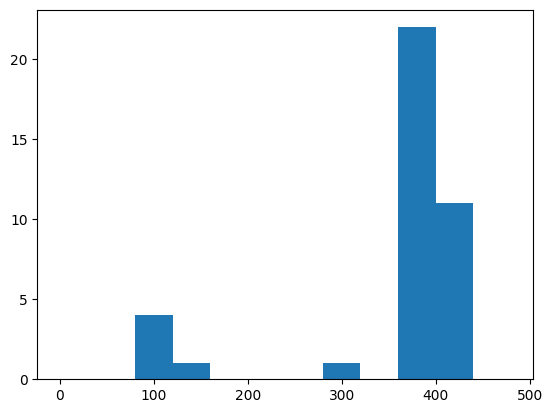

In [423]:
plt.hist(result_df['score'][result_df['class'] == 'A'],bins=range(0, 500, 40))

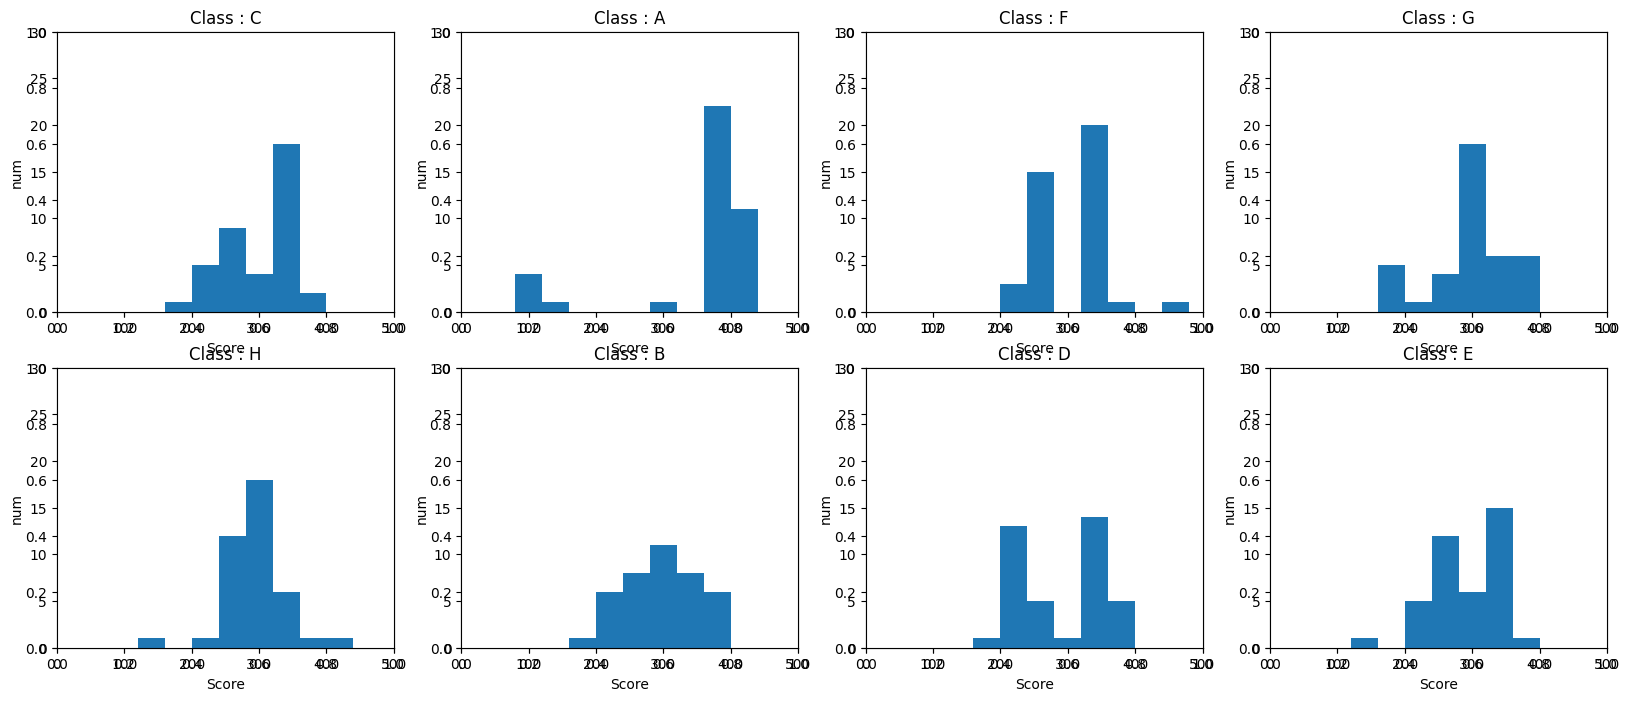

In [434]:
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
for i, c in enumerate(result_df['class'].unique()):
    cls_df = result_df[result_df['class']==c]
    ax = fig.add_subplot(
        2, 4, i+1,
        xlabel = 'Score', ylabel = 'num',
        xlim=(0, 500), ylim=(0, 30),
        title=f'Class : {c}'
        )
    ax.hist(cls_df['score'], bins=range(0, 500, 40))